# Multi-Class Text Classification - Unbalanced Dataset

Inspired by Susan Li's article: https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

The goal is to classifying consumer finance complaints into 9 pre-defined classes. 
<br>The classifier makes the assumption that each new complaint is assigned to one and only one category.

In [1]:
import pandas as pd
df = pd.read_csv('./data/Consumer_Complaints.csv')
df.head()

C:\Programming\Anaconda3\envs\sklearn\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,09/28/2019,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company believes it acted appropriately as aut...,First Federal Credit Control,MD,21117,NaN,Other,Web,09/28/2019,Closed with explanation,Yes,NaN,3389408
1,09/27/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,ALLY FINANCIAL INC.,NY,113XX,Servicemember,NaN,Web,09/27/2019,In progress,Yes,NaN,3388472
2,09/27/2019,Mortgage,Other type of mortgage,Trouble during payment process,NaN,NaN,NaN,LAND HOME FINANCIAL SERVICES,NV,89436,NaN,NaN,Web,09/27/2019,In progress,Yes,NaN,3388560
3,09/27/2019,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,NaN,NaN,"Eagle Accounts Group, Inc.",KY,401XX,NaN,NaN,Web,09/27/2019,Closed with explanation,Yes,NaN,3388118
4,09/27/2019,Debt collection,Credit card debt,False statements or representation,Indicated you were committing crime by not pay...,NaN,NaN,NAVY FEDERAL CREDIT UNION,MD,21043,Servicemember,NaN,Web,09/27/2019,In progress,Yes,NaN,3387872


In this project, we will not use all columns but only "**Product**" and "**Consumer complaint narrative**".

**Input**: Consumer complaint narrative.
<br>**Output**: Product (what we want to predict).

## Data preprocessing

We need to clean the data (missing values) and add a column encoding the Product as an integer because categorical variables are often better represented by integers than strings.
<br><br>For practical reasons, we only take the first 15000 rows of the dataset.

In [2]:
from io import StringIO

df = df[['Product', 'Consumer complaint narrative']]
df.columns = ['Product', 'Consumer_complaint_narrative']

df = df[pd.notnull(df['Consumer_complaint_narrative'])]

df = df.head(15000)

df['category_id'] = df['Product'].factorize()[0]

category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

df.head()

,Product,Consumer_complaint_narrative,category_id
267,Debt collection,Regarding case no- XXXX I don't know what was ...,0
285,Debt collection,I received a letter stating i owned this compa...,0
289,Debt collection,This amount is XXXX dollars is not mine and Im...,0
297,Debt collection,XX/XX/2019 Called my employer XX/XX/2019 Calle...,0
328,Debt collection,"XXXX XXXX XXXX XXXX XXXX XXXX XXXX, GA XXXX CR...",0


### Imbalanced data 

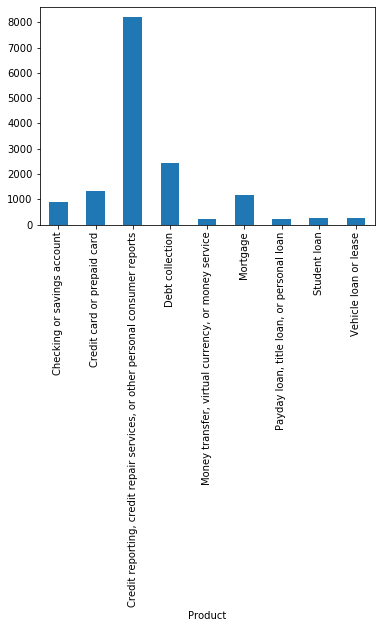

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure()
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

We see that the complaint's number per product is imbalanced. We have to know that conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration. In our case, it's not a problem because the majority class might be of our great interest. It is desirable to have a classifier that gives high prediction accuracy over the majority class, while maintaining reasonable accuracy for the minority classes.

### Text Representation

In machine learning, the features have to be numerical attributes to perform some mathematical operation.
<br>In our dataset, the feature (**consumer complaint narrative**) is a string value. 
<br>To convert our string value into vector of numerical value, we use the vectorization
<br><br>In our case, we will use one vectorization's method based on the Bag-of-Words model (BoW): **Tf-idf**
<br>*Note: BoW is a model where for each document, the presence of words is taken into consideration but the order in which they occur is ignored.*

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf.fit(df.Consumer_complaint_narrative)

features = tfidf.transform(df.Consumer_complaint_narrative)
labels = df.category_id
features.shape

(15000, 20191)

Each of 15000 **consumer complaint narratives** is represented by 20191 features representing the **tf-idf score** for different unigrams.

## Multi-Class Classifier

We will benchmark the following four models:
- Logistic Regression
- Multinomial Naive Bayes
- Linear Support Vector Machine
- Random Forest

### Training 

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(solver='newton-cg', multi_class='multinomial'),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [8]:
entries

[('RandomForestClassifier', 0, 0.5454545454545454),
 ('RandomForestClassifier', 1, 0.5456362425049966),
 ('RandomForestClassifier', 2, 0.5458180606464512),
 ('RandomForestClassifier', 3, 0.5461820606868957),
 ('RandomForestClassifier', 4, 0.5465776293823038),
 ('LinearSVC', 0, 0.8331668331668332),
 ('LinearSVC', 1, 0.8337774816788808),
 ('LinearSVC', 2, 0.8387204265244919),
 ('LinearSVC', 3, 0.8419473157719239),
 ('LinearSVC', 4, 0.8260434056761269),
 ('MultinomialNB', 0, 0.5577755577755578),
 ('MultinomialNB', 1, 0.555962691538974),
 ('MultinomialNB', 2, 0.5624791736087971),
 ('MultinomialNB', 3, 0.5625208402800934),
 ('MultinomialNB', 4, 0.5629382303839733),
 ('LogisticRegression', 0, 0.8121878121878122),
 ('LogisticRegression', 1, 0.8211192538307794),
 ('LogisticRegression', 2, 0.8293902032655781),
 ('LogisticRegression', 3, 0.8426142047349117),
 ('LogisticRegression', 4, 0.8250417362270451)]

We have the accuracy for each sample tested via Cross-Validation method for each model. We will make an average for each model to keep only one value.

In [9]:
scores = {}
sum = 0

for name, i, acc in entries:
    if i == 0:
        sum = 0
    sum += acc
    if i == 4:
        scores[name] = sum/CV
        
scores    

{'RandomForestClassifier': 0.5459337077350386,
 'LinearSVC': 0.8347310925636513,
 'MultinomialNB': 0.5603352987174791,
 'LogisticRegression': 0.8260706420492253}

### Results comparison

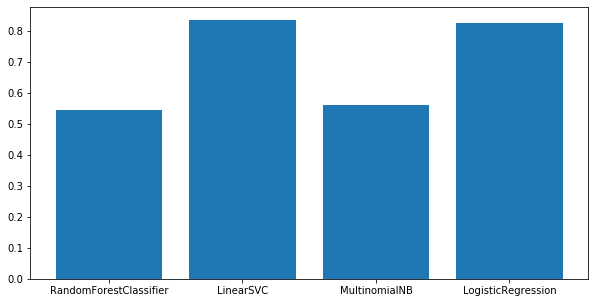

In [10]:
plt.figure(figsize=(10, 5))
plt.bar(scores.keys(), height= scores.values()) 
plt.show()

### Model evaluation

We see that the LinearSVC() algorithm got the best results. So we're going to continue with it.

#### Classification report for each class

In [12]:
from sklearn import metrics
from sklearn.model_selection import train_test_split

model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.2, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred, target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

                                                             Debt collection       0.77      0.75      0.76       466
Credit reporting, credit repair services, or other personal consumer reports       0.89      0.94      0.91      1616
                                                                    Mortgage       0.88      0.90      0.89       242
                                   Payday loan, title loan, or personal loan       0.87      0.34      0.49        38
                                                 Credit card or prepaid card       0.78      0.74      0.76       294
                                                       Vehicle loan or lease       0.61      0.54      0.57        56
                          Money transfer, virtual currency, or money service       0.65      0.40      0.49        43
                                                 Checki

#### Confusion matrix

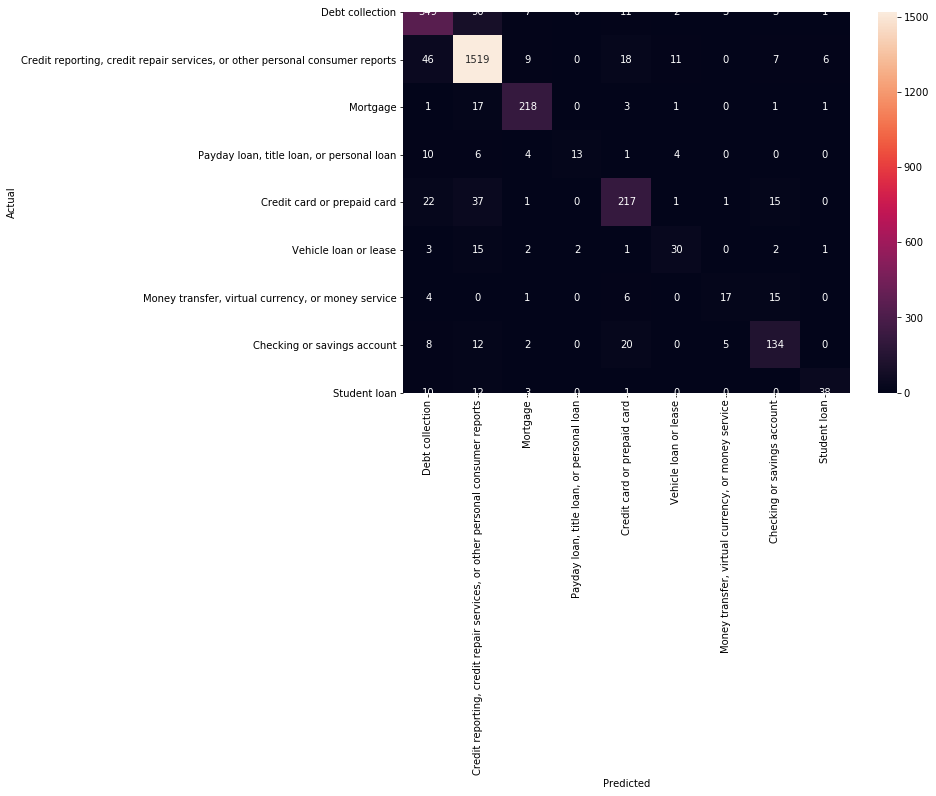

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The majority of the predictions end up on the diagonal, which means that the predictions are good.
<br>Note: diagonal &#8594; predicted label = actual label
<br><br>However, there are a number of misclassifications. Let's try to find the reason.

In [15]:
from IPython.display import display

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 40:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
            print('')

'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Debt collection' : 46 examples.


,Product,Consumer_complaint_narrative
32235,"Credit reporting, credit repair services, or o...",XXXX XXXX XXXX XXXX account # XXXX amount due ...
22923,"Credit reporting, credit repair services, or o...","I had my credit report ran, and found out that..."
44388,"Credit reporting, credit repair services, or o...",There was a collection on my account from XXXX...
22691,"Credit reporting, credit repair services, or o...","I have filed disputes with transunion, XXXX an..."
24702,"Credit reporting, credit repair services, or o...",I just recently reviewed my credit report and ...
7151,"Credit reporting, credit repair services, or o...",I have disputed the age of a medical bill at l...
39796,"Credit reporting, credit repair services, or o...",XXXX has jacked up my bill from a legitimate a...
53310,"Credit reporting, credit repair services, or o...",Hello. \n\nI originally had a collection accou...
49011,"Credit reporting, credit repair services, or o...",i have been receiving calls from this company ...
11902,"Credit reporting, credit repair services, or o...",I sent a certified letter to ProCollect regard...



'Debt collection' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 90 examples.


,Product,Consumer_complaint_narrative
49457,Debt collection,Ive tried disputing this account reporting ina...
41958,Debt collection,I received a notification on Saturday XXXX XXX...
31979,Debt collection,XX/XX/XXXX I receive letter from collection ag...
48790,Debt collection,on XX/XX/XXXX XXXX XXXX XXXX XXXX sold debt th...
22320,Debt collection,Medicredit has mis-managed my account previous...
...,...,...
9993,Debt collection,2013 XXXX insurance paid off the total damaged...
51526,Debt collection,I filed for bankruptcy chapter XXXX on XX/XX/X...
14767,Debt collection,MARINER FINACE IS REPORT TO MY CREDIT REPORT A...
1209,Debt collection,I have no knowledge of this account or the cre...


Let's look the message **32235** in detail.
<br>It was predicted as "**Debt collection**" instead of "**Credit reporting, credit repair services, or other personal consumer reports**".

In [16]:
print(df.Consumer_complaint_narrative[32235])

XXXX XXXX XXXX XXXX account # XXXX amount due : {XXXX} provider of service : THE XXXX XXXX XXXX Under the FAIR DEBT COLLECTION PRACTICES ACT I am allowed to protect my privacy and medical records from third parties. I do not recall giving my permission to the XXXX XXXX XXXX to release my medical records to a third party. HIPAA does allow for limited information about me but anything more is to only be revealed with the patients authorization.


We can see that this complaint touch on more than one subject. That's why the prediction failed.